In [2]:
# %%
import cv2
import gtsam
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
from scipy.spatial.transform import Rotation as R
import gtsam.utils.plot as gtsam_plot
from warnings import warn
import rospy
from std_msgs.msg import Header
from geometry_msgs.msg import PoseStamped, Point
from sensor_msgs.msg import PointCloud2, PointField
from sensor_msgs import point_cloud2 as pc2
import struct
from nav_msgs.msg import Path
import itertools


plt.rcParams['figure.figsize'] = [20, 10]


In [3]:
rospy.init_node('pathfinder', anonymous=True)

In [117]:

kScaleKitti = 1  

class GroundTruth(object):
   def __init__(self, path, associations=None):
       self.path=path 
       self.associations=associations 
       self.filename=None
       self.file_associations=None         
       self.data=None 
       self.scale = 1

   def getDataLine(self, frame_id):
       return self.data[frame_id].strip().split()
   
   def getPoseAndAbsoluteScale(self, frame_id):
       return 0,0,0,1

   # convert the dataset into 'Simple' format  [x,y,z,scale]
   def convertToSimpleXYZ(self, filename='groundtruth.txt'):
       out_file = open(filename,"w")
       num_lines = len(self.data)
       print('num_lines:', num_lines)
       for ii in range(num_lines):
           x,y,z,scale = self.getPoseAndAbsoluteScale(ii)
           if ii == 0:
               scale = 1 # first sample: we do not have a relative 
           out_file.write( "%f %f %f %f \n" % (x,y,z,scale) )
       out_file.close()

class KittiGroundTruth(GroundTruth):
   def __init__(self, filename, associations=None): 
       super().__init__(filename, associations)
       self.scale = kScaleKitti
       self.filename= filename   # N.B.: this may depend on how you deployed the groundtruth files 
       with open(self.filename) as f:
           self.data = f.readlines()
           self.found = True 
       if self.data is None:
           sys.exit('ERROR while reading groundtruth file: please, check how you deployed the files and if the code is consistent with this!') 

   def getPoseAndAbsoluteScale(self, frame_id1, frame_id2):
       assert frame_id1 < frame_id2
       ss = self.getDataLine(frame_id1)
       x_prev = self.scale*float(ss[3])
       y_prev = self.scale*float(ss[7])
       z_prev = self.scale*float(ss[11])     
       ss = self.getDataLine(frame_id2) 
       x = self.scale*float(ss[3])
       y = self.scale*float(ss[7])
       z = self.scale*float(ss[11])
       abs_scale = np.sqrt((x - x_prev)*(x - x_prev) + (y - y_prev)*(y - y_prev) + (z - z_prev)*(z - z_prev))
       return x,y,z,abs_scale 




In [134]:
_S = []

def zero_transform():
    return np.hstack((np.identity(3), np.zeros((3,1))))

class Frame():
    def __init__(self, id, kps, descs):
        self.id = id
        self.kps = kps
        self.descs = descs

class Star():
    _id = itertools.count(0)

    def __init__(self, frame1, kp_index1, frame2, kp_index2, initial_estiamte):
        self.symbol = gtsam.symbol('s', next(self._id))
        self.initial_estimate = initial_estiamte
        self.observations = { frame1: kp_index1, frame2: kp_index2 }
    def add_observation(self,frame, kp_index):
        if frame in self.observations:
            if kp_index == self.observations[frame]:
                return
            # warn("Star: tried to add a Frame #{} observation twice with differect KP indices ({}, {})".format(frame.id, self.observations[frame], kp_index))
            del self.observations[frame]
        else:
            self.observations[frame] = kp_index
    def has(self, frame, kp_index):
        return frame in self.observations and self.observations[frame] == kp_index

class Transform():
    def __init__(self, frame1, frame2, R, t):
        assert frame1.id < frame2.id

        self.frame1 = frame1
        self.frame2 = frame2
        self.R = R
        self.t = t
    
    def __add__(self, transform2):
        assert isinstance(transform2, Transform)
        t = self.t + (self.R @ transform2.t)
        R = transform2.R @ self.R
        return Transform(self.frame1, transform2.frame2, R, t)

    def projection_matrix(self):
        x,y,z = self.t.T[0]
        rot = self.R
        return np.hstack((rot, [[x],[y],[z]]))
    
class Processor():
    def __init__(self, path):
        self.frames = glob.glob(path)
        self.frames.sort()
        self.pp = (601.8873, 183.1104)
        self.focal = 707.0912
        self.detector = cv2.AKAZE_create()
        self.truth = KittiGroundTruth("/images/poses.txt")

        self.pointer = 1
        self.m_rotation = None
        self.m_translation = None
        self.transform = None

        frame = self.detectAndComputeFrame(0)
        self.prev_kps = frame.kps
        self.prev_descs = frame.descs
        self.bf = cv2.BFMatcher(cv2.NORM_HAMMING) # TODO replace?

        self.track = []
        self.processed_frames = []
        self.transforms = {}
        self.stars = []
        
    
    def detectAndComputeFrame(self, i):
        frame = cv2.imread(self.frames[i], cv2.IMREAD_GRAYSCALE)
        (next_kps, next_descs) = self.detector.detectAndCompute(frame, None)
        frame = Frame(i, next_kps, next_descs)
        return frame

    def estimate_transform(self, frame1, frame2, global_transform=None, debug=False):
        matches = self.bf.knnMatch(frame1.descs, frame2.descs, k=2)
        
        matches_prev = []
        matches_next = []
        
        if debug:
            debug_frames = [cv2.imread(self.frames[frame1.id]), cv2.imread(self.frames[frame2.id])]

        matches = list(filter(lambda m: m[0].distance < 0.8*m[1].distance, matches))
        if len(matches) < 500:
            return None

        for m,n in matches:
            matches_prev.append(frame1.kps[m.queryIdx].pt)
            matches_next.append(frame2.kps[m.trainIdx].pt)

            if debug:
                pa = (int(matches_prev[-1][0]),int(matches_prev[-1][1]))
                pb = (int(matches_next[-1][0]),int(matches_next[-1][1]))
                debug_frames[0] = cv2.line(debug_frames[0], pa, pb, (0,255,0), 1) 
                debug_frames[1] = cv2.line(debug_frames[1], pa, pb, (0,255,0), 1) 
                     

        matches_prev = np.array(matches_prev)
        matches_next = np.array(matches_next)

        E, mask = cv2.findEssentialMat(matches_prev, matches_next, focal=self.focal, pp=self.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        points, R_est, t_est, mask_pose = cv2.recoverPose(E, matches_prev, matches_next, focal=self.focal, pp=self.pp)
        
        x,y,z,scale = self.truth.getPoseAndAbsoluteScale(frame1.id, frame2.id)
        t_est *= scale

        transform = Transform(frame1, frame2, R_est, t_est)

        if global_transform is not None:
            points_4d = cv2.triangulatePoints(zero_transform(), transform.projection_matrix(), matches_prev.T, matches_next.T)
            points_3d = points_4d[0:3] / points_4d[3]
            ponits_3d = global_transform.t + (global_transform.R @ points_3d)
            for i,(m,n) in enumerate(matches):
                star = next((s for s in self.stars if s.has(frame1, m.queryIdx)), None)
                if star:
                    star.add_observation(frame2, m.trainIdx)
                else:
                    self.stars.append(Star(frame1, m.queryIdx, frame2, m.trainIdx, ponits_3d[:,i]))

        if debug:
            return transform, debug_frames
        return transform


p = Processor("/images/*.png")
_f = [p.detectAndComputeFrame(0), p.detectAndComputeFrame(1), p.detectAndComputeFrame(2)]
_t = p.estimate_transform(_f[0], _f[1], Transform(Frame(-2, [], []), Frame(-1, [], []), np.identity(3), np.zeros((3,1))))
_t = p.estimate_transform(_f[1], _f[2], _t)
# plt.imshow(p.last_frame)




In [135]:
p = Processor("/images/*.png")

frames = []
for i in tqdm(range(40)):
    frames.append(p.detectAndComputeFrame(i))


100%|██████████| 40/40 [00:02<00:00, 14.90it/s]


In [136]:
_, (im1, im2) = p.estimate_transform(frames[20], frames[30], debug=True)
plt.imshow(np.vstack((im1, im2)))

TypeError: cannot unpack non-iterable NoneType object

In [137]:
global_transform = None
track = []

PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3]*6))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3]*6))

graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()
graph.add(gtsam.PriorFactorPose3(0, gtsam.Pose3(), PRIOR_NOISE))
initial_estimate.insert(0, gtsam.Pose3())



for i in tqdm(range(1, len(frames))):
    transform = p.estimate_transform(frames[i-1], frames[i], global_transform=global_transform)
    if global_transform is None:
        global_transform = transform
    else:
        global_transform += transform 

    x,y,z,_ = p.truth.getPoseAndAbsoluteScale(transform.frame1.id, transform.frame2.id)
    track.append([global_transform.t.T[0], [x, y, z]])

    x,y,z = global_transform.t.T[0]
    rot = gtsam.Rot3(global_transform.R)
    initial_estimate.insert(i, gtsam.Pose3(rot, gtsam.Point3(x,y,z)))

    x,y,z = transform.t.T[0]
    rot = gtsam.Rot3(transform.R)
    graph.add(gtsam.BetweenFactorPose3(i-1, i, gtsam.Pose3(rot, gtsam.Point3(x,y,z)), ODOMETRY_NOISE))

    for j in np.random.choice(range(1,5), 4):
        i_ahead = i+j
        if len(frames) <= i_ahead:
            break
        transform = p.estimate_transform(frames[i-1], frames[i_ahead])
        if not transform:
            continue

        x,y,z = transform.t.T[0]
        rot = gtsam.Rot3(transform.R)
        graph.add(gtsam.BetweenFactorPose3(i-1, i_ahead, gtsam.Pose3(rot, gtsam.Point3(x,y,z)), ODOMETRY_NOISE))

track = np.array(track)

100%|██████████| 39/39 [00:23<00:00,  1.69it/s]


In [140]:
noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)
K = gtsam.Cal3_S2(p.focal, p.focal, 0, p.pp[0], p.pp[1])
p.stars.sort(reverse=True, key=lambda s: len(s.observations))
best_stars = p.stars[:1000]
for star in best_stars:
    for frame, kp_index in star.observations.items():
        xy = np.array(frame.kps[kp_index].pt, dtype=np.float64)
        graph.add(gtsam.GenericProjectionFactorCal3_S2(xy, noise, frame.id, star.symbol, K))

In [141]:
for star in best_stars:
    initial_estimate.insert(star.symbol, star.initial_estimate)

In [149]:
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
factor = gtsam.PriorFactorPoint3(best_stars[0].symbol, best_stars[0].initial_estimate[:,np.newaxis], point_noise)
graph.push_back(factor)

In [151]:
parameters = gtsam.GaussNewtonParams()

def dogleg_optimizer():
    params = gtsam.DoglegParams()
    params.setVerbosity('TERMINATION')
    return gtsam.Cal3_S2(graph, initial_estimate, params)

def gauss_newton_optimizer():
    # Stop iterating once the change in error between steps is less than this value
    parameters.setRelativeErrorTol(1e-5)
    # Do not perform more than N iteration steps
    parameters.setMaxIterations(1000)
    # Create the optimizer ...
    return gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)

def lm_optimizer():
    params = gtsam.LevenbergMarquardtParams()
    params.setVerbosityLM("ERROR")
    return gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)


optimizer = lm_optimizer() 
# ... and optimize
result = optimizer.optimize()
# print("Final Result:\n{}".format(result))

# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
# for i in range(1, len(result.keys())):
#     print("X{} covariance:\n{}\n".format(i, marginals.marginalCovariance(i)))

# fig = plt.figure(0)
# for i in range(1, len(result.keys())):
#     gtsam_plot.plot_pose3(0, result.atPose3(i), 0.5, marginals.marginalCovariance(i))

# plt.axis('equal')
# plt.show()

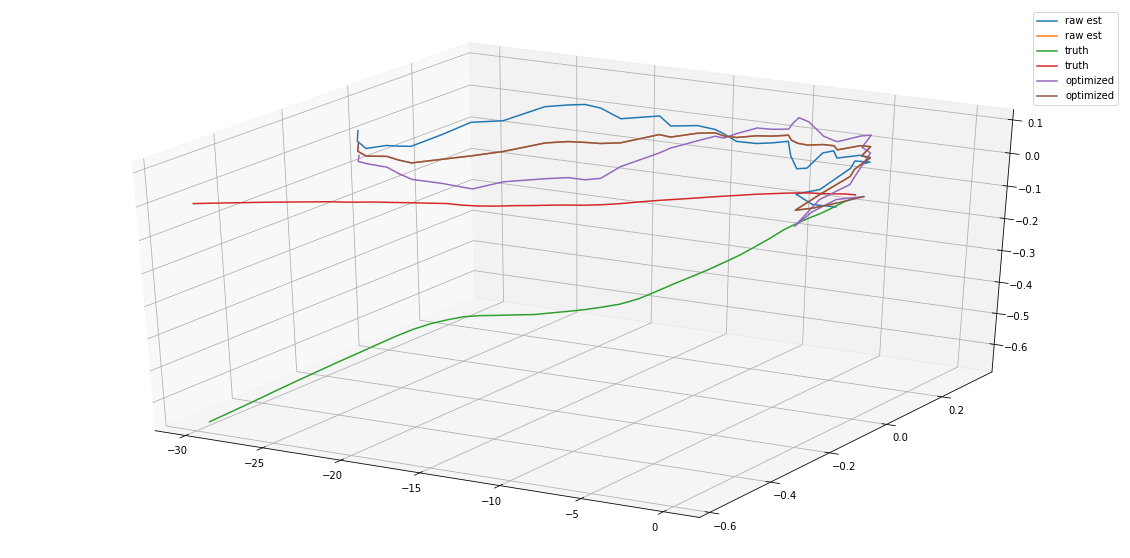

In [153]:
optimized = np.array([[result.atPose3(f.id).x(), result.atPose3(f.id).y(),result.atPose3(f.id).z()] for f in frames])

plt.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

def plot3(x, y, z, label):
    ax.plot(x, y, z, label=label)
    ax.plot(x, y, 0, label=label)

plot3(track[:,0,2], track[:,0,0], track[:,0,1], label="raw est")
plot3(-track[:,1,2], track[:,1,0], track[:,1,1], label="truth")
plot3(optimized[:,2], optimized[:,0], -optimized[:,1], label="optimized")
ax.legend()

plt.show()
# track

In [160]:
import struct
class TracePoints():
    def __init__(self, topic="debug_points", frame_id="map"):
        self.publisher = rospy.Publisher(topic, PointCloud2, queue_size=1)
        self.frame_id = frame_id
        
        self.fields = [PointField('x', 0, PointField.FLOAT32, 1),
          PointField('y', 4, PointField.FLOAT32, 1),
          PointField('z', 8, PointField.FLOAT32, 1),
          # PointField('rgb', 12, PointField.UINT32, 1),
          PointField('rgba', 12, PointField.UINT32, 1),
        ]
        self.reset()

    def reset(self):
        self.points = []

    def add_point(self, point, color):
        x = point[0] / 100.0
        y = point[1] / 100.0
        z = point[2] / 100.0
        r = int(color[0] * 255.0)
        g = int(color[1] * 255.0)
        b = int(color[2] * 255.0)
        a = 255
        rgb = struct.unpack('I', struct.pack('BBBB', b, g, r, a))[0]
        pt = [x, y, z, rgb]
        print([x, y, z, rgb])
        self.points.append(pt)
        
    def publish(self):
        header = Header()
        header.frame_id = self.frame_id
        msg = pc2.create_cloud(header, self.fields, self.points)
        self.publisher.publish(msg)

tp = TracePoints()
for star in best_stars:
    tp.add_point(result.atPoint3(star.symbol), [.07,.3,.9])
    # tp.add_point(star.initial_estimate, [.9,.07,.3])
tp.publish()

[-1.466486461151568, -0.21060367783651554, -0.00046717968247874997, 4279323877]
[-1.757890293979508, -0.29241892081562404, -0.0002635542143004832, 4279323877]
[-1.6960785546986816, -0.46411779300978057, -0.000518460535249492, 4279323877]
[-1.6759561549395996, -0.5203006160940582, -0.0007081843332410687, 4279323877]
[-1.6641785666081292, -0.5521580137571359, -0.0008260250300611388, 4279323877]
[-1.6709552124445188, -0.5345497462576139, -0.0007175920884854786, 4279323877]
[-1.6651653338677874, -0.549361776505784, -0.0007896596585650151, 4279323877]
[-1.7541191699454937, -0.3027291709466348, -0.0003315362322601656, 4279323877]
[-1.7496802137379617, -0.31501180358008457, -0.00035803863723359974, 4279323877]
[-1.760023974247997, -0.28832438727010756, -0.00010732167266666481, 4279323877]
[-1.7113765715160998, -0.42133340048756096, -0.0009099741194655792, 4279323877]
[-1.7149612281918545, -0.4113097396438017, -0.0007224655783846768, 4279323877]
[-1.7131370813151923, -0.41665234123863426, -0.0

In [156]:
def viz_path(X, Y, Z, label):
    path_publisher = rospy.Publisher(label, Path, queue_size=1)

    path_msg = Path()
    path_msg.header.frame_id = 'map'
    for x, y, z in zip(X, Y, Z):
        pose_msg = PoseStamped()

        pose_msg.pose.position.x = x / 100
        pose_msg.pose.position.y = y / 100
        pose_msg.pose.position.z = z / 100
        pose_msg.pose.orientation.x = 0
        pose_msg.pose.orientation.y = 0
        pose_msg.pose.orientation.z = 0
        pose_msg.pose.orientation.w = 1
        path_msg.poses.append(pose_msg)

    path_publisher.publish(path_msg)
    
viz_path(track[:,0,2], track[:,0,0], track[:,0,1], label="raw_est")
viz_path(-track[:,1,2], track[:,1,0], track[:,1,1], label="truth")
viz_path(optimized[:,2], optimized[:,0], -optimized[:,1], label="optimized")

In [157]:
"""
GTSAM Copyright 2010, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
Authors: Frank Dellaert, et al. (see THANKS for the full author list)
See LICENSE for the license information
A structure-from-motion problem on a simulated dataset
"""
from __future__ import print_function

import gtsam
import matplotlib.pyplot as plt
import numpy as np
from gtsam import symbol_shorthand
L = symbol_shorthand.L
X = symbol_shorthand.X

from gtsam.examples import SFMdata
from gtsam import (Cal3_S2, DoglegOptimizer,
                         GenericProjectionFactorCal3_S2, Marginals,
                         NonlinearFactorGraph, PinholeCameraCal3_S2, Point3,
                         Pose3, PriorFactorPoint3, PriorFactorPose3, Rot3, Values)
from gtsam.utils import plot


def main():
    """
    Camera observations of landmarks (i.e. pixel coordinates) will be stored as Point2 (x, y).
    Each variable in the system (poses and landmarks) must be identified with a unique key.
    We can either use simple integer keys (1, 2, 3, ...) or symbols (X1, X2, L1).
    Here we will use Symbols
    In GTSAM, measurement functions are represented as 'factors'. Several common factors
    have been provided with the library for solving robotics/SLAM/Bundle Adjustment problems.
    Here we will use Projection factors to model the camera's landmark observations.
    Also, we will initialize the robot at some location using a Prior factor.
    When the factors are created, we will add them to a Factor Graph. As the factors we are using
    are nonlinear factors, we will need a Nonlinear Factor Graph.
    Finally, once all of the factors have been added to our factor graph, we will want to
    solve/optimize to graph to find the best (Maximum A Posteriori) set of variable values.
    GTSAM includes several nonlinear optimizers to perform this step. Here we will use a
    trust-region method known as Powell's Degleg
    The nonlinear solvers within GTSAM are iterative solvers, meaning they linearize the
    nonlinear functions around an initial linearization point, then solve the linear system
    to update the linearization point. This happens repeatedly until the solver converges
    to a consistent set of variable values. This requires us to specify an initial guess
    for each variable, held in a Values container.
    """

    # Define the camera calibration parameters
    K = Cal3_S2(50.0, 50.0, 0.0, 50.0, 50.0)

    # Define the camera observation noise model
    measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v

    # Create the set of ground-truth landmarks
    points = SFMdata.createPoints()

    # Create the set of ground-truth poses
    poses = SFMdata.createPoses(K)

    # Create a factor graph
    graph = NonlinearFactorGraph()

    # Add a prior on pose x1. This indirectly specifies where the origin is.
    # 0.3 rad std on roll,pitch,yaw and 0.1m on x,y,z
    pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
    factor = PriorFactorPose3(X(0), poses[0], pose_noise)
    graph.push_back(factor)

    # Simulated measurements from each camera pose, adding them to the factor graph
    for i, pose in enumerate(poses):
        camera = PinholeCameraCal3_S2(pose, K)
        for j, point in enumerate(points):
            measurement = camera.project(point)
            print('measurement', type(measurement), measurement.shape, measurement, measurement.dtype)
            print(measurement)
            return
            factor = GenericProjectionFactorCal3_S2(
                measurement, measurement_noise, X(i), L(j), K)
            graph.push_back(factor)

    # Because the structure-from-motion problem has a scale ambiguity, the problem is still under-constrained
    # Here we add a prior on the position of the first landmark. This fixes the scale by indicating the distance
    # between the first camera and the first landmark. All other landmark positions are interpreted using this scale.
    point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
    factor = PriorFactorPoint3(L(0), points[0], point_noise)
    graph.push_back(factor)
    graph.print_('Factor Graph:\n')

    # Create the data structure to hold the initial estimate to the solution
    # Intentionally initialize the variables off from the ground truth
    initial_estimate = Values()
    for i, pose in enumerate(poses):
        transformed_pose = pose.retract(0.1*np.random.randn(6,1))
        initial_estimate.insert(X(i), transformed_pose)
    for j, point in enumerate(points):
        transformed_point = point + 0.1*np.random.randn(3)
        initial_estimate.insert(L(j), transformed_point)
    initial_estimate.print_('Initial Estimates:\n')

    # Optimize the graph and print results
    params = gtsam.DoglegParams()
    params.setVerbosity('TERMINATION')
    optimizer = DoglegOptimizer(graph, initial_estimate, params)
    print('Optimizing:')
    result = optimizer.optimize()
    result.print_('Final results:\n')
    print('initial error = {}'.format(graph.error(initial_estimate)))
    print('final error = {}'.format(graph.error(result)))

    marginals = Marginals(graph, result)
    plot.plot_3d_points(1, result, marginals=marginals)
    plot.plot_trajectory(1, result, marginals=marginals, scale=8)
    plot.set_axes_equal(1)
    plt.show()

main()

measurement <class 'numpy.ndarray'> (2,) [67.17960677 37.5       ] float64
[67.17960677 37.5       ]
